In [3]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [4]:
cali_df = pd.read_csv('Cali_cleaned_penal_codes.csv', encoding='ISO-8859-1')
nyc_df = pd.read_csv('NYC_cleaned_penal_codes.csv', encoding='ISO-8859-1')

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
print("California DF Columns:", cali_df.columns)
print("New York DF Columns:", nyc_df.columns)

California DF Columns: Index(['id', 'citation', 'State'], dtype='object')
New York DF Columns: Index(['id', 'citation', 'State'], dtype='object')


In [10]:
# Ensure all citation text entries are strings
cali_df['citation'] = cali_df['citation'].astype(str)
nyc_df['citation'] = nyc_df['citation'].astype(str)


# Tokenize the citation text from both datasets
tokens_cali = tokenizer(cali_df['citation'].tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")
tokens_nyc = tokenizer(nyc_df['citation'].tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")

In [11]:
with torch.no_grad():
    outputs_cali = model(input_ids=tokens_cali['input_ids'], attention_mask=tokens_cali['attention_mask'])
    embeddings_cali = outputs_cali.last_hidden_state.mean(dim=1)

# Generate embeddings for New York penal codes
with torch.no_grad():
    outputs_nyc = model(input_ids=tokens_nyc['input_ids'], attention_mask=tokens_nyc['attention_mask'])
    embeddings_nyc = outputs_nyc.last_hidden_state.mean(dim=1)

In [12]:
avg_embedding_cali = embeddings_cali.mean(dim=0, keepdim=True)
avg_embedding_nyc = embeddings_nyc.mean(dim=0, keepdim=True)

# Calculate cosine similarity between the average embeddings
similarity = cosine_similarity(avg_embedding_cali.cpu().numpy(), avg_embedding_nyc.cpu().numpy())

In [13]:
print(similarity)

[[0.98569566]]


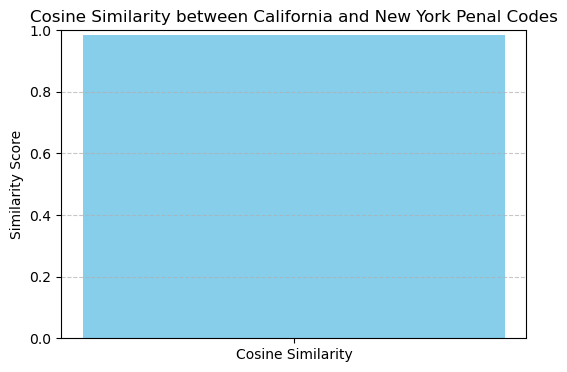

In [14]:
# Plotting
plt.figure(figsize=(6, 4))
plt.bar(['Cosine Similarity'], [similarity.item()], color=['skyblue'])
plt.title('Cosine Similarity between California and New York Penal Codes')
plt.ylabel('Similarity Score')
plt.ylim(0, 1)  # Cosine similarity ranges from -1 to 1, but -1 would indicate complete dissimilarity
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()